# This is a file for preprocessing data and for searching of optimal number of clusters

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
#df = pd.read_csv('pact.csv', sep = '|', low_memory = False)
#print df
pactcsv = 'pact2.csv'
pinfocsv = 'pinfo2.csv'

convertion of info from file to data

In [3]:
def convert(s):
            try:
                return int(s)
            except:
                pass
            try:
                return float(s)
            except:
                # booleans
                if s == 'False':
                    return 0
                elif s=='True':
                    return 1
                # genders
                elif s=='f':
                    return -1
                elif s=='m':
                    return 1
                else:
                    return s

In [4]:
# preprocess some data
#with open(pinfocsv, 'rb') as f:
#    reader = csv.reader(f,  delimiter='|')
#    name_list = None
#    values = dict()
#    for row in reader:
#        if name_list == None:
#            name_list = row
#            print name_list
#        else:
#            values[int(row[0])]=[convert(x) for x in row]
#    f.close()
#lens = set()
#for x in values:
#    lens.add(len(values[x]))
#print lens

This part loads info from pact.csv and calculate values for clustering

In [5]:
import sys
values = dict()
with open (pactcsv,'r') as f:
    reader = csv.reader(f,  delimiter='|')
    names2 = None
    values2 = []
    for row in reader:
        if names2 == None:
            names2 = row
            print names2
        else:
            values2.append([convert(x) for x in row])

values2.sort(key = lambda x: x[0]) # sort by ID
index = 0
names =['id','actcount', 'med_ml_num','buynum', 'grind','quests_speed']
while index < len(values2):
    ID = values2[index][0]
    i = index + 1
    while i< len(values2) and values2[i][0] == ID:
        i +=1
    sl = values2[index:i-1]
    q = len(sl)
    if q==0:
        index+=1
        continue
    try:
        values[ID] = [ID]
        values[ID].append(q)
        def to_float(s):
            try:
                return float(s)
            except:
                return 0
        values[ID].append((max([to_float(x[6]) for x in sl])-min([to_float(x[6]) for x in sl]))*1.0/q)# speed of ml_num 
        values[ID].append(sum([to_float(x[12]) for x in sl])*1.0/q) # medium count of buynum
        try:
            values[ID].append(sum([to_float(x[11]) for x in sl])*1.0/q) # medium grind
        except IndexError:
            values[ID].append(0)
        values[ID].append((max([to_float(x[8]) for x in sl])-min([to_float(x[8]) for x in sl]))*1.0/q) # quest speed
    except Exception as err:
        print "ERROR: "+format(err) 
        print ID
        print sl
    index = i
lens = set()
for ID in values:
    lens.add(len(values[ID]))
print lens

['id', 'actdate', 'actdate_num', 'actflag', 'payflag', 'pgrflag', 'ml_num', 'transactions', 'quests_end', 'm_quests_end', 'grindnum', 'asknum', 'buynum', 'crystallnum', 'days_from_last_actdate', 'days_from_last_payment']
set([6])


Here we save our data to temporary file

In [6]:
with open('tmp.txt','wb') as f:
    writer = csv.writer(f, delimiter='|',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(names)
    for ID in values:
        if len(values[ID])==9:
            values[ID] += [0,0,0,0,0]
        writer.writerow(values[ID])
    f.close()

In [1]:
df = pd.read_csv('tmp.txt', sep = '|', low_memory = False)
df

NameError: name 'pd' is not defined

This is calculation of clusters with different number of centroids

In [42]:
clusters = []
for cluster_num in xrange(3,8):
    i = 0
    kmeans = KMeans(n_clusters = cluster_num)
    kmeans.fit(df.ix[:,['actcount','med_ml_num','buynum', 'grind','quests_speed']])
    best = kmeans
    for x in range(5):
        kmeans = KMeans(n_clusters = cluster_num)
        kmeans.fit(df.ix[:,['actcount','med_ml_num','buynum', 'grind','quests_speed']])
        if kmeans.inertia_<best.inertia_:
            best = kmeans
    clusters.append(best)
    print "Done for %d"%cluster_num

Done for 3
Done for 4
Done for 5
Done for 6
Done for 7


Show info of clustering

In [43]:
for kmeans,i in zip(clusters,xrange(3,8)):
    print "For number of clusters %d:"%i
    print "Inertia "+"{:10.4f}".format(kmeans.inertia_)
    for x in kmeans.cluster_centers_:
        print '  '.join("{:10.4f}".format(i) for i in x)

For number of clusters 3:
Inertia 195481322.9306
    3.0885      0.0117      0.5764      1.2439      0.6503
   21.3391      0.0930     11.0859    404.9290      5.5140
    4.9412      0.0810     12.7314   1867.3107      6.0100
For number of clusters 4:
Inertia 150455254.9375
    3.0675      0.0116      0.5707      1.1124      0.6476
    4.5351      0.0951     19.8742   1268.4983      6.6696
   12.0000      0.1353      0.5920   3606.8373      5.6230
   24.7312      0.0913      9.5904    316.6254      5.1220
For number of clusters 5:
Inertia 108657443.2572
    1.4508      0.0106      0.3596      0.4964      0.6375
    4.5351      0.0951     19.8742   1268.4983      6.6696
   12.0000      0.1353      0.5920   3606.8373      5.6230
   20.8351      0.0914      9.4283    344.6899      5.4372
   65.8890      0.0537      8.8570     27.8969      1.0879
For number of clusters 6:
Inertia 85503574.4815
    1.4535      0.0107      0.3685      0.5943      0.6415
   16.1429      0.1219      0.8457   4

This is visualization for a "elbow rule"

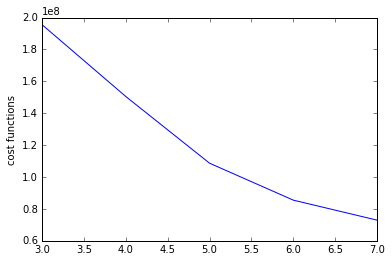

In [44]:
plt.plot(xrange(3,8),[x.inertia_ for x in clusters])
plt.ylabel('cost functions')
plt.show()